In [2]:
#Importing libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
#clearing existing paths
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")
if os.path.exists("./test_tensor_y.npy"):
    os.remove("./test_tensor_y.npy")
if os.path.exists("./test_tensor_x.npy"):
    os.remove("./test_tensor_x.npy")

In [4]:
#Defining hyperparameters
epochs = 100
batch_size = 16
lr = 1e-3
alpha = 0.1
resize_height = 256
resize_width = 256
ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

In [5]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,
                        )
    height, width, _ = y.shape
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],
                        'bicubic',
                        antialias=True,
                        )
    x = x / 255.0
    y = y / 255.0
    return x, y

In [6]:
#Uploading images for training, validation and testing from 2 different datasets DIV2K and Urban100
img_paths = []
val_img_paths = []
test_img_paths = []
for dirname, _, filenames in os.walk('ISR_DIV2K/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('ISR_DIV2K/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('urban100'):
    for filename in filenames:
        test_img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]

print('Training: ', len(img_paths))

print('Test dataset dimension: ', len(test_img_paths))

Dataset dimension:  900
Training:  810
Test dataset dimension:  100


In [7]:
#converting train set images into arrays
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')


100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [02:34<00:00,  5.24it/s]


In [8]:
#converting validation set images into arrays
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.60it/s]


In [18]:
#converting test set images into arrays
if not (os.path.exists('./test_tensor_x.npy')) or not (os.path.exists('./test_tensor_y.npy')):

    test_img_lr = []
    test_img_hr = []

    for i in tqdm(range(len(test_img_paths))):
        x, y = preprocessing(test_img_paths[i], ratio, resize_height, resize_width)
        test_img_lr.append(x)
        test_img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(test_img_lr).numpy()
    tensor_y = tf.convert_to_tensor(test_img_hr).numpy()
    tensor_x.shape

    np.save('./test_tensor_x.npy', tensor_x)
    np.save('./test_tensor_y.npy', tensor_y)
    test_img_lr = tensor_x
    test_img_hr = tensor_y
else:
    test_img_lr = np.load('./test_tensor_x.npy')
    test_img_hr = np.load('./test_tensor_y.npy')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.67it/s]


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
def srcnn_model(input_shape):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=input_shape))
    
    # Upsampling Layer 1
    model.add(UpSampling2D(size=(2, 2)))
    
    # Convolutional Layer 2
    model.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
    
    # Upsampling Layer 2
    model.add(UpSampling2D(size=(2, 2)))
    
    # Convolutional Layer 3 (Output layer)
    model.add(Conv2D(3, (5, 5), activation='relu', padding='same'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    model.summary()
    
    return model

In [11]:
input_shape = (None, None, 3) 
model = srcnn_model(input_shape)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    15616     
                                                                 
 up_sampling2d (UpSampling2  (None, None, None, 64)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    2080      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, None, None, 32)    0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     2403      
                                                                 
Total params: 20099 (78.51 KB)
Trainable params: 20099

In [26]:
srcnn_history=model.fit(img_lr, img_hr,batch_size=16, epochs=300, validation_data=(val_img_lr, val_img_hr))

Epoch 1/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 2/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 3/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 5/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/300
7/7 [==============================] - 12s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 7/300
7/7 [==============================] - 

7/7 [==============================] - 9s 1s/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 53/300
7/7 [==============================] - 10s 2s/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 54/300
7/7 [==============================] - 9s 1s/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 55/300
7/7 [==============================] - 9s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 56/300
7/7 [==============================] - 9s 1s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 57/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 58/300
7/7 [==============================] - 9s 2s/

7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 104/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 105/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 106/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 107/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 108/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 109/300
7/7 [==============================] - 9

7/7 [==============================] - 9s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 155/300
7/7 [==============================] - 9s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 156/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 157/300
7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 158/300
7/7 [==============================] - 9s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 159/300
7/7 [==============================] - 9s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 160/300
7/7 [==============================] - 9

7/7 [==============================] - 9s 1s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 206/300
7/7 [==============================] - 9s 2s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 207/300
7/7 [==============================] - 9s 1s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 208/300
7/7 [==============================] - 9s 1s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 209/300
7/7 [==============================] - 9s 1s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 210/300
7/7 [==============================] - 9s 1s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 211/300
7/7 [==============================] - 9

7/7 [==============================] - 13s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 257/300
7/7 [==============================] - 13s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 258/300
7/7 [==============================] - 13s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 259/300
7/7 [==============================] - 13s 2s/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 260/300
7/7 [==============================] - 13s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 261/300
7/7 [==============================] - 13s 2s/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 262/300
7/7 [=============================

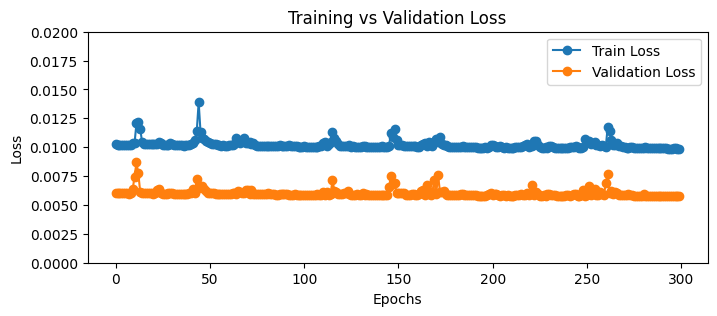

In [34]:
plt.figure(figsize=(8, 3))
plt.plot(srcnn_history.history['loss'], label='Train Loss', marker='o')
plt.plot(srcnn_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 0.02])
plt.legend()
plt.show()

In [35]:
validation_loss = model.evaluate(val_img_lr, val_img_hr)
print("Validation Loss:", validation_loss)

26/26 [==============================] - 9s 355ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Validation Loss: [0.00578570831567049, 0.00578570831567049]


In [61]:
test_loss = model.evaluate(test_img_lr, test_img_hr)
print("Test Loss:", test_loss)

4/4 [==============================] - 2s 178ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Test Loss: [0.009912810288369656, 0.009912810288369656]


In [36]:
outputs =  model.predict(test_img_lr)

4/4 [==============================] - 1s 276ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


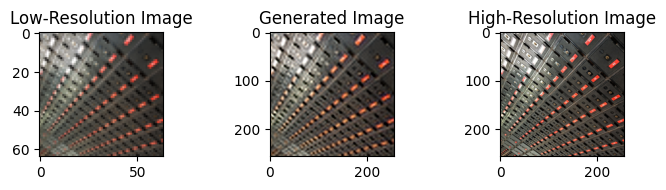

In [74]:
plt.figure(figsize=(7, 2))

plt.subplot(1, 3, 1)
plt.imshow(test_img_lr[5])
plt.title('Low-Resolution Image')

plt.subplot(1, 3, 2)
plt.imshow(outputs[5])
plt.title('Generated Image')

plt.subplot(1, 3, 3)
plt.imshow(test_img_hr[5])
plt.title('High-Resolution Image')

plt.tight_layout()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


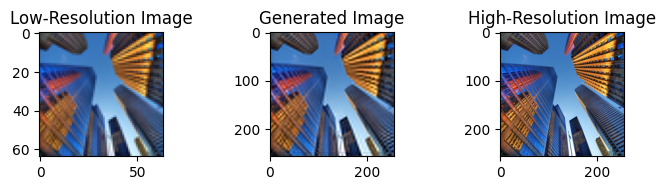

In [73]:
plt.figure(figsize=(7, 2))

plt.subplot(1, 3, 1)
plt.imshow(test_img_lr[11])
plt.title('Low-Resolution Image')

plt.subplot(1, 3, 2)
plt.imshow(outputs[11])
plt.title('Generated Image')

plt.subplot(1, 3, 3)
plt.imshow(test_img_hr[11])
plt.title('High-Resolution Image')

plt.tight_layout()

plt.show()

In [54]:
from skimage.metrics import peak_signal_noise_ratio as psnr


def calculate_psnr(img1, img2, data_range=None):
    psnr_value = psnr(img1, img2, data_range=data_range)
    return psnr_value

psnr_value = calculate_psnr(test_img_hr[11], outputs[11], data_range=255)

print(f"PSNR: {psnr_value} dB")

PSNR: 68.83796663983213 dB


In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D

def very_deep_srcnn_model(input_shape):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(128, (9, 9), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Convolutional Layer 2
    model.add(Conv2D(128, (1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Upsampling Layer 1
    model.add(UpSampling2D(size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(64, (7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Convolutional Layer 4
    model.add(Conv2D(64, (1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Upsampling Layer 2
    model.add(UpSampling2D(size=(2, 2)))

    # Convolutional Layer 5
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Convolutional Layer 6 (Output layer)
    model.add(Conv2D(3, (5, 5), activation='relu', padding='same'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    # Print the model summary
    model.summary()

    return model



In [59]:
input_shape = (None, None, 3)  # Adjust the input shape based on your actual input data
vdsr_model = very_deep_srcnn_model(input_shape)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, None, None, 128)   31232     
                                                                 
 batch_normalization (Batch  (None, None, None, 128)   512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, None, None, 128)   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 128)   16512     
                                                                 
 batch_normalization_1 (Bat  (None, None, None, 128)   512       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, None, None, 128) 

In [60]:
vdsr_history=vdsr_model.fit(img_lr, img_hr,batch_size=16, epochs=100, validation_data=(val_img_lr, val_img_hr))

Epoch 1/100
7/7 [==============================] - 192s 30s/step - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.1809 - val_mean_squared_error: 0.1809
Epoch 2/100
7/7 [==============================] - 188s 30s/step - loss: 0.0769 - mean_squared_error: 0.0769 - val_loss: 0.4610 - val_mean_squared_error: 0.4610
Epoch 3/100
7/7 [==============================] - 187s 30s/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.2308 - val_mean_squared_error: 0.2308
Epoch 4/100
7/7 [==============================] - 188s 30s/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.1930 - val_mean_squared_error: 0.1930
Epoch 5/100
7/7 [==============================] - 188s 30s/step - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0542 - val_mean_squared_error: 0.0542
Epoch 6/100
7/7 [==============================] - 187s 30s/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0583 - val_mean_squared_error: 0.0583
Epoch 7/100
7/7 [=================

7/7 [==============================] - 126s 20s/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 52/100
7/7 [==============================] - 126s 20s/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 53/100
7/7 [==============================] - 127s 20s/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 54/100
7/7 [==============================] - 126s 20s/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 55/100
7/7 [==============================] - 127s 20s/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 56/100
7/7 [==============================] - 127s 20s/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 57/100
7/7 [=======================

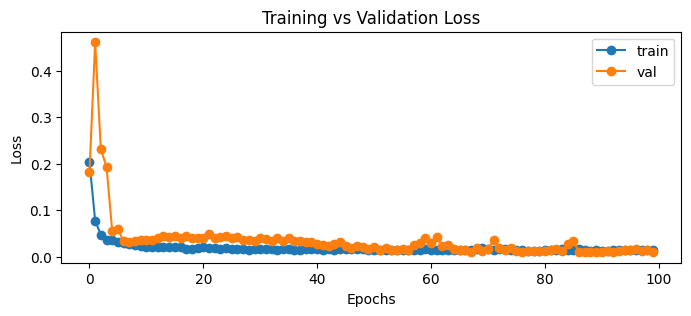

In [63]:
plt.figure(figsize=(8, 3))
plt.plot(vdsr_history.history['loss'], label='train', marker='o')
plt.plot(vdsr_history.history['val_loss'], label='val', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
vdsr_validation_loss = vdsr_model.evaluate(val_img_lr, val_img_hr)

print("Validation Loss:", vdsr_validation_loss)

26/26 [==============================] - 89s 3s/step - loss: 0.0107 - mean_squared_error: 0.0107
Validation Loss: [0.010688500478863716, 0.010688500478863716]


In [65]:
vdsr_test_loss = vdsr_model.evaluate(test_img_lr, test_img_hr)
print("Test Loss:", vdsr_test_loss)

4/4 [==============================] - 11s 3s/step - loss: 0.0136 - mean_squared_error: 0.0136
Test Loss: [0.01356139499694109, 0.01356139499694109]


In [66]:
vdsr_outputs =  vdsr_model.predict(test_img_lr)

4/4 [==============================] - 11s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


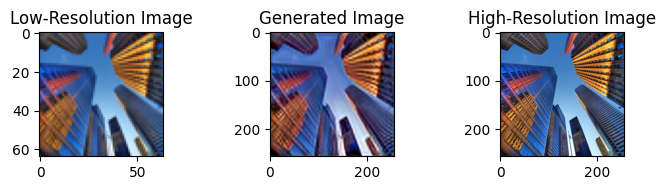

In [72]:
plt.figure(figsize=(7, 2))

plt.subplot(1, 3, 1)
plt.imshow(test_img_lr[11])
plt.title('Low-Resolution Image')

plt.subplot(1, 3, 2)
plt.imshow(vdsr_outputs[11])
plt.title('Generated Image')

plt.subplot(1, 3, 3)
plt.imshow(test_img_hr[11])
plt.title('High-Resolution Image')

plt.tight_layout()

plt.show()

In [71]:
from skimage.metrics import peak_signal_noise_ratio as psnr


def calculate_psnr(img1, img2, data_range=None):
    psnr_value = psnr(img1, img2, data_range=data_range)
    return psnr_value

psnr_value = calculate_psnr(test_img_hr[11], vdsr_outputs[11], data_range=255)

print(f"PSNR: {psnr_value} dB")

PSNR: 67.27804602537591 dB
